# 03: Preliminary Sequential Quadratic Programming 
Date: 2022-07-19

In [4]:
import cvxopt
from cvxopt import matrix
from cvxopt import solvers
import numpy as np
import matplotlib.pyplot as plt
import random

import pandas as pd
import os
#os.chdir('..')
from scipy.stats import norm

import cvxpy as cp
import torch
from cvxpylayers.torch import CvxpyLayer

## Python `cvxopt` package experimentation 

Notes and code following the tutorial [here](https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf). 

### CVXOPT notation: 

Minimize x: $\frac{1}{2}x^{T}Px + q^{T}x$

Subject to: $ Gx \leq h $ and $Ax = b$

### Example 1 

Minimize $x, y$: $\frac{1}{2}x^2 + 3x + 4y $

Subject to: 

$ x, y \geq 0$ 

$x + 3y \geq 15$

$2x + 5y \leq 100 $

$3x + 4y \leq 80$

This is rewritten into the following form: 

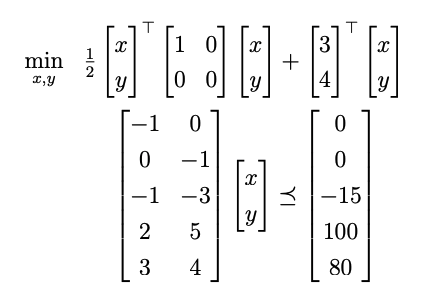

In [13]:
P = np.array([[1, 0], [0, 0]])
q = np.array([[3], [4]])
G = np.array([[-1, 0], [0, -1], [-1, -3], [2, 5], [3, 4]])
h = np.array([[0, 0, -15, 100, 80]]).T

In [21]:
# convert numpy arrays to matrix 
# tc = 'd' makes numbers doubles
P = matrix(P, tc = 'd')
q = matrix(q, tc = 'd')
G = matrix(G, tc = 'd')
h = matrix(h, tc = 'd')

In [23]:
# solve the problem 

sol = solvers.qp(P, q, G, h)

     pcost       dcost       gap    pres   dres
 0:  1.0780e+02 -7.6366e+02  9e+02  0e+00  4e+01
 1:  9.3245e+01  9.7637e+00  8e+01  1e-16  3e+00
 2:  6.7311e+01  3.2553e+01  3e+01  1e-16  1e+00
 3:  2.6071e+01  1.5068e+01  1e+01  1e-16  7e-01
 4:  3.7092e+01  2.3152e+01  1e+01  8e-17  4e-01
 5:  2.5352e+01  1.8652e+01  7e+00  6e-17  2e-16
 6:  2.0062e+01  1.9974e+01  9e-02  1e-16  0e+00
 7:  2.0001e+01  2.0000e+01  9e-04  2e-16  4e-16
 8:  2.0000e+01  2.0000e+01  9e-06  3e-16  0e+00
Optimal solution found.


In [25]:
print(sol['x'])

[ 7.13e-07]
[ 5.00e+00]



In [26]:
print(sol['primal objective'])

20.00000617311241


In [28]:
sol.keys()

dict_keys(['x', 'y', 's', 'z', 'status', 'gap', 'relative gap', 'primal objective', 'dual objective', 'primal infeasibility', 'dual infeasibility', 'primal slack', 'dual slack', 'iterations'])

In [29]:
sol['iterations']

8

In [31]:
sol['primal infeasibility']

3.044181283464691e-16

## Play with `cvxopt` on paper data

This is the sequential quadratic programming problem that has to be solved in the paper: 

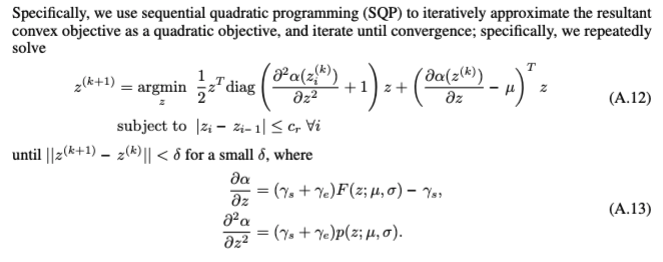

In [5]:
# read in actual load data 
y = pd.read_csv('data/processed_data/load_day.csv')

In [6]:
y.head()

,date,load_0,load_1,load_2,load_3,load_4,load_5,load_6,load_7,load_8,...,load_14,load_15,load_16,load_17,load_18,load_19,load_20,load_21,load_22,load_23
0,2008-01-01 00:00:00-05:00,1.638353,1.477345,1.414483,1.363922,1.335267,1.317172,1.336110,1.390134,1.384562,...,1.673765,1.694973,1.729332,1.796148,1.888417,1.889696,1.877055,1.867986,1.846560,1.746222
1,2008-01-02 00:00:00-05:00,1.638353,1.547900,1.501405,1.498565,1.515585,1.549149,1.632906,1.772550,1.865784,...,1.938833,1.919035,1.897486,1.915997,2.051433,2.109081,2.078931,2.045422,2.009802,1.875147
2,2008-01-03 00:00:00-05:00,1.748204,1.657729,1.631283,1.618455,1.602828,1.637414,1.707257,1.864876,1.974241,...,1.993449,1.940367,1.957562,1.961049,2.090424,2.125197,2.121473,2.073546,2.012757,1.911130
3,2008-01-04 00:00:00-05:00,1.792341,1.713451,1.666581,1.632931,1.618902,1.660159,1.737172,1.893254,1.984880,...,1.953248,1.937801,1.889109,1.889635,2.004978,1.999592,2.004797,1.934830,1.924758,1.802445
4,2008-01-05 00:00:00-05:00,1.685581,1.613860,1.547408,1.510216,1.480833,1.466431,1.494527,1.591901,1.639697,...,1.746762,1.756344,1.752150,1.770546,1.868841,1.863735,1.840670,1.792914,1.758059,1.677769


In [7]:
# set params 
c_ramp = 0.4
gamma_under = 50
gamma_over = 0.5

<AxesSubplot:title={'center':'mu for every hour'}>

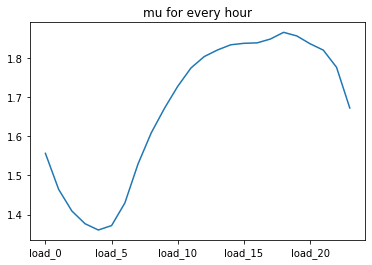

In [8]:
# get mu and sigma for each hour 
loads = y.drop('date', axis = 1)
mu = loads.apply(np.mean)
sigma = loads.apply(np.std)
# print mu and sigma
%matplotlib inline
mu.plot(title = "mu for every hour")

<AxesSubplot:title={'center':'sigma for every hour'}>

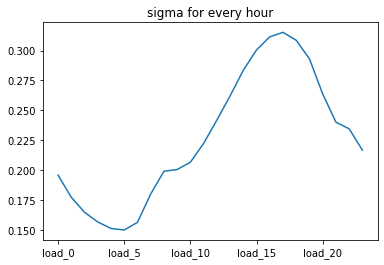

In [174]:
sigma.plot(title = "sigma for every hour")

In [114]:
def calc_dz(mu, sigma, z): 
    """
    mu: vector of means
    sigma: vector of sigmas
    z: estimate of load (24 hours)
    """
    cdf = norm.cdf(z, loc = mu, scale = sigma) 
    return (gamma_over + gamma_under)*cdf - gamma_under

def calc_dz2(mu, sigma, z): 
    """
    mu: vector of means
    sigma: vector of sigmas
    z: estimate of load (24 hours)
    """
    pdf = norm.pdf(z, loc = mu, scale = sigma)
    return (gamma_over + gamma_under)*pdf

In [9]:
loads.loc[1, :]

load_0     1.638353
load_1     1.547900
load_2     1.501405
load_3     1.498565
load_4     1.515585
load_5     1.549149
load_6     1.632906
load_7     1.772550
load_8     1.865784
load_9     1.911896
load_10    1.979420
load_11    1.979113
load_12    1.968179
load_13    1.956842
load_14    1.938833
load_15    1.919035
load_16    1.897486
load_17    1.915997
load_18    2.051433
load_19    2.109081
load_20    2.078931
load_21    2.045422
load_22    2.009802
load_23    1.875147
Name: 1, dtype: float64

In [115]:
calc_dz(loads.loc[1, :], mu, sigma)

array([-41.05947946, -41.1775454 , -41.34026869, -41.67248743,
       -42.01760103, -42.22476942, -42.38122167, -42.47988586,
       -42.41785663, -42.27451182, -42.30309208, -41.8655596 ,
       -41.45440174, -41.11723597, -40.74336182, -40.44747082,
       -40.19651962, -40.24406029, -41.16045372, -41.72240234,
       -41.84814763, -41.88978723, -41.98214481, -41.88709159])

In [116]:
calc_dz2(loads.loc[1, :], mu, sigma)

array([8.42596231, 8.87976841, 9.11932805, 9.10258453, 8.95854099,
       8.73200014, 8.26876871, 7.66148688, 7.32319412, 7.13710001,
       6.88883424, 6.95568228, 7.06562326, 7.17540125, 7.31039128,
       7.43892416, 7.55336395, 7.49113406, 6.98031288, 6.72544506,
       6.73104062, 6.76859498, 6.88384894, 7.36825878])

In [181]:
# Get the P, Q, G, h needed for optimization 

# P = diag(dz2 + 1) 
dz2 = calc_dz2(loads.loc[1, :], mu, sigma)
P = np.diag(dz2 + 1)

# q = (dz - mu)T
dz = calc_dz(loads.loc[1, :], mu, sigma)
q = np.array((dz - mu)).reshape((24, 1))

# G and h are related to our ramping constraint 
# create matrix G that satisifies: 
# Gz <= h where G is s.t. z2 - z1 <= h, z3 - z2 <= h, ... etc. 
# Then, for 3 z's, we want G (2 x 3) to look like: 
# [[-1, 1, 0],
#  [0, -1, 1], 

diagnols = np.repeat(-1, 24)
matrix_diagnol = np.diag(diagnols)
diagnols2 = np.repeat(1, 23)
matrix_diagnol2 = np.diag(diagnols2, 1)

add_diagnols = matrix_diagnol + matrix_diagnol2
G = add_diagnols[:23, :]
h = np.repeat(c_ramp, 23)

In [182]:
# convert numpy arrays to matrix 
# tc = 'd' makes numbers doubles
P = matrix(P, tc = 'd')
q = matrix(q, tc = 'd')
G = matrix(G, tc = 'd')
h = matrix(h, tc = 'd')

In [183]:
# solve the problem 
sol = solvers.qp(P, q, G, h)

     pcost       dcost       gap    pres   dres
 0: -2.6269e+03 -2.6371e+03  1e+01  0e+00  1e-02
 1: -2.6270e+03 -2.6273e+03  3e-01  7e-16  3e-04
 2: -2.6270e+03 -2.6270e+03  6e-03  8e-16  5e-06
 3: -2.6270e+03 -2.6270e+03  7e-05  1e-15  6e-08
Optimal solution found.


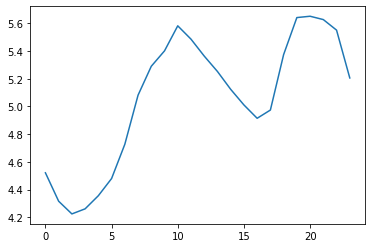

In [184]:
# New load values found
plt.plot(sol['x'])

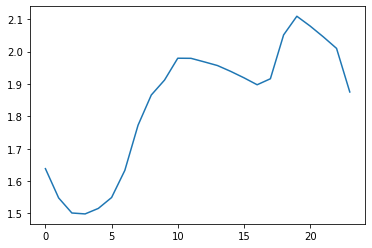

In [179]:
# Original load values 
plt.plot(np.array(loads.loc[1, :]))

It seems like the new load values are twice the amount of what it used to be. At first, I thought I was missing a factor of 2 somewhere but the set up looks correct. 

#### Factors that may be affecting this

- I played around with the cost parameters and it seems this factor of 2 might be because the cost of undergenerating is so much higher than the cost of overgenerating. That's so interesting! I wonder what implications this will have.. 

- I realized also that I was misunderstanding what the $\mu$ and $\sigma$ parameters should be. The $\mu$ should be the output of the neural net model, and the $\sigma$ should be the RMSE of the model (standard deviation of the errors). This will result in a smaller $\sigma$.

See below for different scenarios.

##### Equal Cost for Over and Undergeneration 

     pcost       dcost       gap    pres   dres
 0: -2.0946e+02 -2.1878e+02  9e+00  0e+00  5e-02
 1: -2.0951e+02 -2.1002e+02  5e-01  5e-16  3e-03
 2: -2.0951e+02 -2.0952e+02  9e-03  4e-16  4e-05
 3: -2.0951e+02 -2.0951e+02  9e-05  5e-16  4e-07
 4: -2.0951e+02 -2.0951e+02  9e-07  4e-16  4e-09
Optimal solution found.


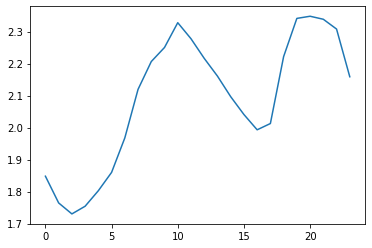

In [185]:
gamma_under = 10
gamma_over = 10

# Get the P, Q, G, h needed for optimization 

# P = diag(dz2 + 1) 
dz2 = calc_dz2(loads.loc[1, :], mu, sigma)
P = np.diag(dz2 + 1)

# q = (dz - mu)T
dz = calc_dz(loads.loc[1, :], mu, sigma)
q = np.array((dz - mu)).reshape((24, 1))


# convert numpy arrays to matrix 
# tc = 'd' makes numbers doubles
P = matrix(P, tc = 'd')
q = matrix(q, tc = 'd')
G = matrix(G, tc = 'd')
h = matrix(h, tc = 'd')

# solve the problem 
sol = solvers.qp(P, q, G, h)

# New load values found
plt.plot(sol['x'])

##### Lower Sigma

     pcost       dcost       gap    pres   dres
 0: -3.1825e+03 -3.1927e+03  4e+01  3e+00  1e-02
 1: -3.1825e+03 -3.1878e+03  5e+00  1e-15  1e-16
 2: -3.1826e+03 -3.1829e+03  3e-01  8e-16  9e-17
 3: -3.1826e+03 -3.1826e+03  1e-02  1e-15  7e-17
 4: -3.1826e+03 -3.1826e+03  1e-04  1e-15  8e-17
Optimal solution found.


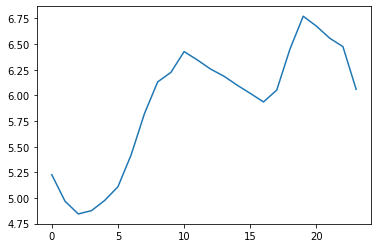

In [189]:
gamma_under = 50
gamma_over = 0.5

# Get the P, Q, G, h needed for optimization 

# P = diag(dz2 + 1) 
dz2 = calc_dz2(loads.loc[1, :], mu, sigma/100)
P = np.diag(dz2 + 1)

# q = (dz - mu)T
dz = calc_dz(loads.loc[1, :], mu, sigma/100)
q = np.array((dz - mu)).reshape((24, 1))


# convert numpy arrays to matrix 
# tc = 'd' makes numbers doubles
P = matrix(P, tc = 'd')
q = matrix(q, tc = 'd')
G = matrix(G, tc = 'd')
h = matrix(h, tc = 'd')

# solve the problem 
sol = solvers.qp(P, q, G, h)

# New load values found
plt.plot(sol['x'])

This actually brings new load values up even more! 

## CVXPY experiment

I realized that I need a differentiable sequential quadratic programming solver. Looking online, there are some packages that allow adding solvers to layers in Pytorch. [This one](https://github.com/cvxgrp/cvxpylayers) seems promising, but I have to use `cvxpy` package. 

In [265]:
# Get the P, Q, G, h needed for optimization 

# P = diag(dz2 + 1) 
dz2 = calc_dz2(loads.loc[1, :], mu, sigma)
P = np.diag(dz2 + 1)

# q = (dz - mu)
dz = calc_dz(loads.loc[1, :], mu, sigma)
q = np.array((dz - mu))

# G and h are related to our ramping constraint 
# create matrix G that satisifies: 
# Gz <= h where G is s.t. z2 - z1 <= h, z3 - z2 <= h, ... etc. 
# Then, for 3 z's, we want G (2 x 3) to look like: 
# [[-1, 1, 0],
#  [0, -1, 1], 

diagnols = np.repeat(-1, 24)
matrix_diagnol = np.diag(diagnols)
diagnols2 = np.repeat(1, 23)
matrix_diagnol2 = np.diag(diagnols2, 1)

add_diagnols = matrix_diagnol + matrix_diagnol2
G = add_diagnols[:23, :]
h = np.repeat(c_ramp, 23)

In [256]:
x = cp.Variable(24)
prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x, P) + q.T @ x), 
                  [G @ x <= h])

In [257]:
# condition for using cvxpylayer
prob.is_dpp()

True

In [196]:
prob.solve()

-2626.9854615920954

In [197]:
print("The optimal values is", prob.value)

The optimal values is -2626.9854615920954


In [198]:
x.value

array([4.52110904, 4.3160881 , 4.22452909, 4.26119862, 4.35588815,
       4.4797343 , 4.72669837, 5.08103169, 5.28964071, 5.40069477,
       5.58137723, 5.48536612, 5.36322063, 5.25201451, 5.12331319,
       5.01066767, 4.91442029, 4.97379877, 5.37379877, 5.64088712,
       5.65049311, 5.62644238, 5.55034509, 5.20527859])

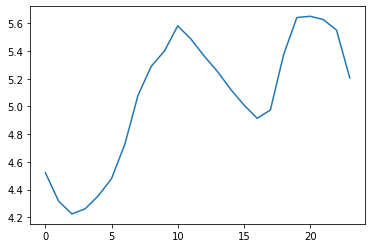

In [199]:
plt.plot(x.value)

## cvxpylayer experiment

In [269]:

# G and h are related to our ramping constraint 
# create matrix G that satisifies: 
# Gz <= h where G is s.t. z2 - z1 <= h, z3 - z2 <= h, ... etc. 
# Then, for 3 z's, we want G (2 x 3) to look like: 
# [[-1, 1, 0],
#  [0, -1, 1], 

diagnols = np.repeat(-1, 24)
matrix_diagnol = np.diag(diagnols)
diagnols2 = np.repeat(1, 23)
matrix_diagnol2 = np.diag(diagnols2, 1)

add_diagnols = matrix_diagnol + matrix_diagnol2
G = add_diagnols[:23, :]
h = np.repeat(c_ramp, 23)

# create cvxpy problem

# P = diag(dz2 + 1) 
dz2 = calc_dz2(loads.loc[1, :], mu, sigma)
dz = calc_dz(loads.loc[1, :], mu, sigma)

x = cp.Variable(24)
P = cp.Parameter((24, 24), PSD = True, value = np.diag(dz2 + 1))
q = cp.Parameter((24), value = np.array(dz-mu))

prob = cp.Problem(cp.Minimize(0.5*cp.quad_form(x, P) + q.T @ x), 
                  [G @ x <= h])

In [270]:
# condition for using cvxpylayer
prob.is_dpp()
#P.curvature

False

In [271]:
prob.solve()

/Users/mnakajim/opt/anaconda3/envs/e2e-model-learning/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


-2626.9854615920954

In [ ]:
cvxpylayer = CvxpyLayer(prob, variables = [x])

TypeError: __init__() missing 1 required positional argument: 'parameters'

In [219]:
n, m = 2, 3
x = cp.Variable(n)
A = cp.Parameter((m, n))
b = cp.Parameter(m)
constraints = [x >= 0]
objective = cp.Minimize(0.5 * cp.pnorm(A @ x - b, p=1))
problem = cp.Problem(objective, constraints)
assert problem.is_dpp()


In [220]:
A

Parameter((3, 2))

In [221]:
b

Parameter((3,))

In [218]:
solutioncvxpylayer = CvxpyLayer(problem, parameters=[A, b], variables=[x])
A_tch = torch.randn(m, n, requires_grad=True)
b_tch = torch.randn(m, requires_grad=True)

# solve the problem
solution, = cvxpylayer(A_tch, b_tch)

# compute the gradient of the sum of the solution with respect to A, b
solution.sum().backward()

## Experiment with `qpth` 

Okay... `cvxpylayer` is not working for me. Try `qpth` package instead. 

In [273]:
from qpth.qp import QPFunction

In [300]:
# Get the P, Q, G, h needed for optimization 

# P = diag(dz2 + 1) 
dz2 = calc_dz2(loads.loc[1, :], mu, sigma)
P = np.diag(dz2 + 1)

# q = (dz - mu)
dz = calc_dz(loads.loc[1, :], mu, sigma)
q = np.array((dz - mu))

# G and h are related to our ramping constraint 
# create matrix G that satisifies: 
# Gz <= h where G is s.t. z2 - z1 <= h, z3 - z2 <= h, ... etc. 
# Then, for 3 z's, we want G (2 x 3) to look like: 
# [[-1, 1, 0],
#  [0, -1, 1], 

diagnols = np.repeat(-1, 24)
matrix_diagnol = np.diag(diagnols)
diagnols2 = np.repeat(1, 23)
matrix_diagnol2 = np.diag(diagnols2, 1)

add_diagnols = matrix_diagnol + matrix_diagnol2
G = add_diagnols[:23, :]
h = np.repeat(c_ramp, 23)

In [301]:
P = torch.from_numpy(P).float()
q = torch.from_numpy(q).float()
G = torch.from_numpy(G).float()
h = torch.from_numpy(h).float()
e = torch.DoubleTensor().float()

In [311]:
solver = QPFunction()

In [312]:
x = solver(P, q, G, h, e, e)

I guess this works? Time to find out if it will work in the neural net... 

In [1]:
solver

NameError: name 'solver' is not defined